# Simple forecast of EV Demand in CT (RL Polk Data)

## Set up

In [146]:
# DataFrame Management
import pandas as pd

# Maths and statistics
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf

# Plotting
from matplotlib import pyplot as plt

# Progress monitoring
from tqdm import tqdm

# Path management
import pathlib

# Date Management
import datetime

# Set up path
path = pathlib.Path().resolve()
data_path = path.parent / "Dropbox" / "DOT_Tobin_Collaboration" / "data"

# Prepare Data

In [2]:
# Import raw data to be used
vehicle_sales = pd.read_csv(data_path / "new_vehicle_sales_month_year_zip.csv")
vehicle_sales = vehicle_sales.drop("Unnamed: 0", axis = 1)

### FIll out zeroes
One of the issues with the vehicle_sales dataset is that year / month / zip code combinations for electric vehicles have no observations (i.e. no EVs were sold in the that zip code, in that year, and that month). This creates issues for zip-by-zip modelling later on. We address this by filling in the data with zeroes for these instances.

In [4]:
# Fill out zeroes
vehicle_sales_filled = vehicle_sales.copy(deep=True)

for year in tqdm(list(range(2018,2023))):
            for month in list(range(1,13)):
                for zip_code in list(vehicle_sales["ZIP_CODE"].unique()):
                    if len(vehicle_sales[(vehicle_sales["month"]==month) 
                                         & (vehicle_sales["year"] == year) 
                                         & (vehicle_sales["FuelTypePrimary"] == "Electric") 
                                         & (vehicle_sales["ZIP_CODE"]== zip_code)])==0:
                        new_df = pd.DataFrame.from_dict({"FuelTypePrimary" : ["Electric"],
                                              "ZIP_CODE": [zip_code],
                                              "VEH_COUNT": [0],
                                              "year":[year],
                                               "month":[ month]}, orient = 'columns')
                        vehicle_sales_filled = pd.concat([vehicle_sales_filled, new_df])
                        
vehicle_sales_filled = vehicle_sales_filled.reset_index(drop=True)

100%|██████████| 5/5 [01:29<00:00, 17.87s/it]


### Filter for EVs only

In [147]:
# Create EV sales data (we create a date column to ease plotting
ev_sales = vehicle_sales.loc[vehicle_sales[vehicle_sales["FuelTypePrimary"] == "Electric"].index, :]
ev_sales.loc[:, "day"] = 1
ev_sales.loc[:,"date"] = pd.to_datetime(ev_sales[["year", "month", "day"]])

In [11]:
# Create EV sales data with zeroes filled (we create a date column to ease plotting)
ev_sales_filled = vehicle_sales_filled.loc[vehicle_sales_filled[vehicle_sales_filled["FuelTypePrimary"] == "Electric"].index, :]
ev_sales_filled.loc[:, "day"] = 1
ev_sales_filled.loc[:,"date"] = pd.to_datetime(ev_sales_filled[["year", "month", "day"]])

### Group by Year (for plotting)

In [13]:
# Group all observations by date (to allow plotting)
ev_sales_zip_grouped = ev_sales.groupby(["date"]).sum()
ev_sales_zip_grouped = ev_sales_zip_grouped.reset_index()
ev_sales_zip_grouped = ev_sales_zip_grouped[["date", "VEH_COUNT"]]

In [215]:
ev_sales[ev_sales["year"]==2021]["VEH_COUNT"].sum()

8404

### Prepare dummy variables for month fixed effects

In [16]:
# Create a month column
ev_sales_zip_grouped["month"] = ev_sales_zip_grouped["date"].astype(str).str[5:7]

# Get month dummies and append these columns to the data frame
month_dummy = pd.get_dummies(ev_sales_zip_grouped["month"], prefix='month')
ev_sales_zip_grouped_dummies = pd.concat([ev_sales_zip_grouped, month_dummy], axis = 1)

# Drop the month column now
ev_sales_zip_grouped_dummies = ev_sales_zip_grouped_dummies.iloc[:, ~ev_sales_zip_grouped_dummies.columns.isin(["month"])]

# Drop the index column and call it time, which runs from 0-60
ev_sales_zip_grouped_dummies= ev_sales_zip_grouped_dummies.reset_index()
ev_sales_zip_grouped_dummies = ev_sales_zip_grouped_dummies.rename(columns = {"index":"time"})

# Drop date
ev_sales_zip_grouped_dummies = ev_sales_zip_grouped_dummies.iloc[:, ~ev_sales_zip_grouped_dummies.columns.isin(["date"])]

# Show
ev_sales_zip_grouped_dummies.head(3)

,time,VEH_COUNT,month_01,month_02,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12
0,0,278,1,0,0,0,0,0,0,0,0,0,0,0
1,1,173,0,1,0,0,0,0,0,0,0,0,0,0
2,2,233,0,0,1,0,0,0,0,0,0,0,0,0


### Create out-of-sample data to be used for prediction later

In [159]:
# Set up prediction data
predict_years = [2018, 2019, 2020, 2021, 2022,2023, 2024, 2025, 2026,2027,2028,2029,2030]
predict_months = [1,2,3,4,5,6,7,8,9,10,11,12]
predict_data = pd.DataFrame([])

i = 0
for year in predict_years:
    for month in predict_months:
        predict_data.loc[i, "year"] = int(year)
        predict_data.loc[i, "month"] = f"{int(month)}".zfill(2)
        predict_data.loc[i, "time"] = int(i)
        i+=1
    
predict_month_dummies = pd.get_dummies(predict_data["month"], prefix = 'month')
predict_data = pd.concat([predict_data, predict_month_dummies], axis = 1)
predict_data["day"] = 1

dates = pd.to_datetime(predict_data[["year", "month", "day"]])

# Grouped Analysis (All ZIP codes)

## Visualize

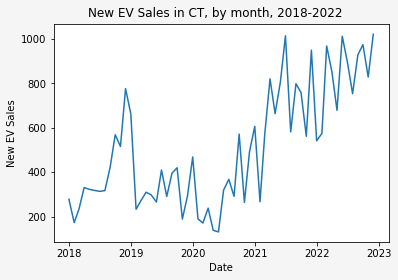

In [148]:
# Create figure and axes
fig, ax = plt.subplots(nrows = 1, ncols = 1, facecolor = 'whitesmoke')

# Add plot
ax.plot(ev_sales_zip_grouped["date"], ev_sales_zip_grouped["VEH_COUNT"])
ax.set_xlabel("Date")
ax.set_ylabel("New EV Sales")

# Create title
fig.suptitle("New EV Sales in CT, by month, 2018-2022", y = 0.94)

# Show
plt.show()

## Linear model with seasonality

In this step we model the data as being generated by a process comprising three parts: a trend component, a seasonal component, and a random noise component. This is similar to a *classical decomposition model* (Brockwell and Davis 2016).
$$
y_t = m_t + s_t+ \epsilon_t
$$

Where:
* $y_t$ is the observation of EV sales for a given month $t$
* $m_t$ is a trend component that we expect to be positive
* $s_t$ is a seasonal component
* $\epsilon_t$ is a random noise component that we expect to be stationary.

More specifically, we expect that $m_t$, the seasonal component, is equal to $\beta_t$, that is, to the time period (from 0-60) multiplied by some constant parameter. This indicates the expectation of a linear trend.

To model the seasonal component $s_t$, we use *fixed effects* (e.g. a fixed effect for the month of January, the month of February, etc.). This reflects an expectation that underlying data-generating process is affected by month-level seasonality (that does not change from year to year)

**Reference:** Brockwell and Davis 2016, Introduction to Time Series Forecasting, Springer, NY.

### Regression formula

In [17]:
y_var_name = "VEH_COUNT"
x_var_name = "time"
dummies = '+'.join([column_name for column_name in ev_sales_zip_grouped_dummies.columns.to_list()[3:]])
form = y_var_name+"~"+x_var_name+"+"+dummies
form

'VEH_COUNT~time+month_02+month_03+month_04+month_05+month_06+month_07+month_08+month_09+month_10+month_11+month_12'

### Estimate

In [18]:
lsdv_model = smf.ols(formula=form, data=ev_sales_zip_grouped_dummies)
lsdv_model_results = lsdv_model.fit()
print(lsdv_model_results.summary())

                            OLS Regression Results                            
Dep. Variable:              VEH_COUNT   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.523
Method:                 Least Squares   F-statistic:                     6.394
Date:                Thu, 12 Oct 2023   Prob (F-statistic):           1.49e-06
Time:                        16:13:06   Log-Likelihood:                -391.11
No. Observations:                  60   AIC:                             808.2
Df Residuals:                      47   BIC:                             835.4
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    256.8167     89.475      2.870      0.0

Note: We use non-robust standard errors, assuming that the data is homoskedastic (i.e. that the variance of the errors is the same for all values of the covariates). This is acceptable, as we are not interested in *inference* at this point.

In [151]:
# Get predictions
predictions = lsdv_model_results.predict(ev_sales_zip_grouped_dummies)

# Get errors
errors = ev_sales_zip_grouped_dummies["VEH_COUNT"].to_list() - predictions

### Plot predicted 

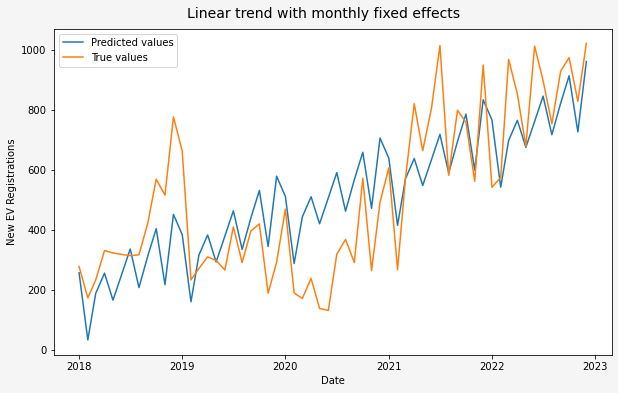

In [158]:
# Create figure
fig, ax = plt.subplots(nrows =1, ncols = 1, figsize = (10,6), facecolor = 'whitesmoke')

# Plot and add axes
ax.plot(ev_sales_zip_grouped["date"], predictions, label = 'Predicted values')
ax.plot(ev_sales_zip_grouped["date"], ev_sales_zip_grouped_dummies["VEH_COUNT"], label = 'True values')
ax.set_xlabel("Date")
ax.set_ylabel("New EV Registrations")

# Add legend
ax.legend(loc= 'best')

# Add title
plt.suptitle("Linear trend with monthly fixed effects", y=0.93, fontsize = 14)

# Show
plt.show()

Visual inspection suggests a linear model fits the data relatively well (and the $R^2$ value of $0.620$ suggests the linear estimation can explain a large proportion of the variance in the data. 

### Observe errors

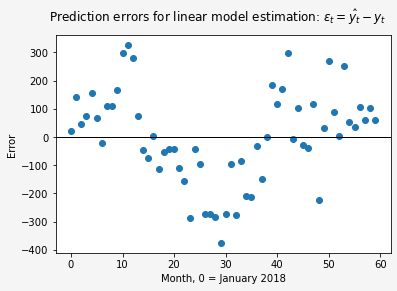

In [73]:
# Create figure
fig, ax = plt.subplots(nrows =1, ncols = 1, facecolor = 'whitesmoke')

# Add errors and a line to show 0
ax.plot(errors, marker = 'o', linestyle = 'none')
ax.axhline(0, color = 'black', linewidth = 1)

# Add x and y axis labels
ax.set_xlabel("Month, 0 = January 2018")
ax.set_ylabel("Error")

# Add figure title
fig.suptitle("Prediction errors for linear model estimation: $\epsilon_t = \hat{y_t} - y_t$")

# show
plt.show()

### Discussion of linear model
Initial observation suggests that the plotted errors are not evenly distributed around 0. This may be an artefact of the data itself (a significant spike in EV registrations in 2019, and a large dip in 2020 during the COVID-19 pandemic). Note: The reason for the spike in EV registrations at the beginning of 2019 is unclear.

**Possible approaches to improve linear model**
* Clip data before 2020 (significant loss of data, not recommended)
* Incorporate COVID pandemic in model (e.g. # of deaths from the pandemic by month, or some other direct incorporation into the model.

### Observe Autocorrelation Function (ACF) for errors.

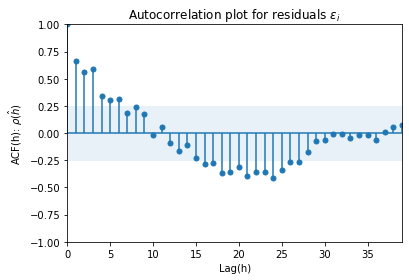

In [132]:
# Create plot
fig, ax = plt.subplots(nrows =1, ncols =1)

# Show +/- 1.96 standard deviations
upper_bound = 1.96/np.sqrt(len(ev_sales_zip_grouped))
lower_bound = -1.96/np.sqrt(len(ev_sales_zip_grouped))
ax.fill_between(np.arange(40), lower_bound, upper_bound, alpha = 0.1)
ax.set_xlim((0,39))
ax.set_xlabel("Lag(h)")
ax.set_ylabel(r"ACF(h): $\hat{\rho(h)}$")

# Show autocorrelation plot
plot_acf(errors,ax=ax,lags = np.arange(40), alpha = None,
        title = "Autocorrelation plot for residuals $\epsilon_i$")

# Show
plt.show()

Again, the sample autocorrelation functions calculated for lags from 0-40 suggest non-stationarity of the series. 

For IID Noise, the sample Autocorrelations should be approximately $\sim N(0,1/n)$ for $n$ sufficiently large. As a consequence, we would expect to see 95% of the observations fall within $\pm 1.96$ standard deviations of 0 (Brockwell and Davis 2016, pp.16-17). This would suggest only two values outside of this range.

However, we observe around 15 values outside of $\pm 1.96$ standard deviations of 0. This again suggests non-stationarity of the series of errors (i.e., in turn that the underlying data generating process is not the linear function of time and month fixed effects that we articulated above). 

**Reference:** Brockwell and Davis 2016, Introduction to Time Series Forecasting, Springer, NY.

### Forecast (linear trend with month fixed effects)

In [160]:
# Create forecast
forecast = lsdv_model_results.predict(predict_data)

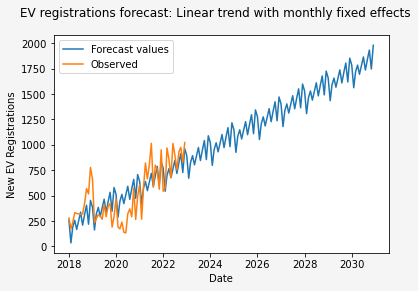

In [161]:
# Create figure
fig, ax = plt.subplots(nrows =1, ncols = 1, facecolor = 'whitesmoke')

# Plot and add axes
ax.plot(dates, forecast, label = 'Forecast values')
ax.plot(ev_sales_zip_grouped["date"], ev_sales_zip_grouped_dummies["VEH_COUNT"], label = 'Observed')
ax.set_xlabel("Date")
ax.set_ylabel("New EV Registrations")

# Add legend
ax.legend(loc= 'best')

# Add title
plt.suptitle("EV registrations forecast: Linear trend with monthly fixed effects")

# Show
plt.show()

In [163]:
int(forecast.sum())

159361

This shows predictions for future EV sales (outside of our current sample) if the linear model estimated above is correct. The model suggests that between 2018 and 2030 160,000 EVs would be sold in CT, much less than the target of 500,000 set by DEEP. 

This forecast shows that if DEEP's prediction is to hold, the trend of EV purchases in CT must be highly *non linear*

Also worth noting is that the month fixed-effects included in the model specification lead to an extremely 'jittery' forecast. This suggests a need for an improved way to model seasonality

## Model 2: Quadratic Trend with Monthly Fixed Effects

### Prepare data

In [80]:
ev_sales_zip_grouped_dummies["time2"] = ev_sales_zip_grouped_dummies["time"]**2
form_2 = y_var_name+"~"+x_var_name+"+time2""+"+dummies
form_2

'VEH_COUNT~time+time2+month_02+month_03+month_04+month_05+month_06+month_07+month_08+month_09+month_10+month_11+month_12'

### Estimate model

In [110]:
lsdv_model_2 = smf.ols(formula=form_2, data=ev_sales_zip_grouped_dummies)
lsdv_model_results_2 = lsdv_model_2.fit()
print(lsdv_model_results_2.summary())

                            OLS Regression Results                            
Dep. Variable:              VEH_COUNT   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.653
Method:                 Least Squares   F-statistic:                     9.539
Date:                Thu, 12 Oct 2023   Prob (F-statistic):           3.70e-09
Time:                        16:45:22   Log-Likelihood:                -380.93
No. Observations:                  60   AIC:                             789.9
Df Residuals:                      46   BIC:                             819.2
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    437.9947     87.135      5.027      0.0

### Plot predictions

In [111]:
predictions_quadratic = lsdv_model_results_2.predict(ev_sales_zip_grouped_dummies)

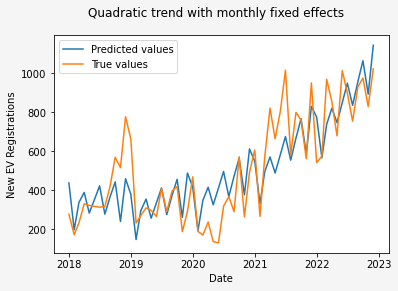

In [112]:
# Create figure
fig, ax = plt.subplots(nrows =1, ncols = 1, facecolor = 'whitesmoke')

# Plot and add axes
ax.plot(ev_sales_zip_grouped["date"], predictions_quadratic, label = 'Predicted values')
ax.plot(ev_sales_zip_grouped["date"], ev_sales_zip_grouped_dummies["VEH_COUNT"], label = 'True values')
ax.set_xlabel("Date")
ax.set_ylabel("New EV Registrations")

# Add legend
ax.legend(loc= 'best')

# Add title
plt.suptitle("Quadratic trend with monthly fixed effects")

# Show
plt.show()

### Observe residuals

In [113]:
errors_quadratic = ev_sales_zip_grouped_dummies["VEH_COUNT"].to_list() - predictions_quadratic

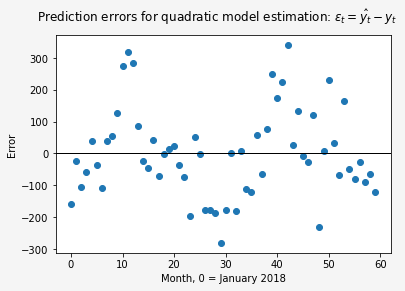

In [114]:
# Create figure
fig, ax = plt.subplots(nrows =1, ncols = 1, facecolor = 'whitesmoke')

# Add errors and a line to show 0
ax.plot(errors_quadratic, marker = 'o', linestyle = 'none')
ax.axhline(0, color = 'black', linewidth = 1)

# Add x and y axis labels
ax.set_xlabel("Month, 0 = January 2018")
ax.set_ylabel("Error")

# Add figure title
fig.suptitle("Prediction errors for quadratic model estimation: $\epsilon_t = \hat{y_t} - y_t$")

# show
plt.show()

Again, the errors generated by the quadratic model appear to show a degree of heteroskedasticity (even periodicity), suggesting that the model does not correctly specify the data generating process.

### Observe Autocorrelation Function

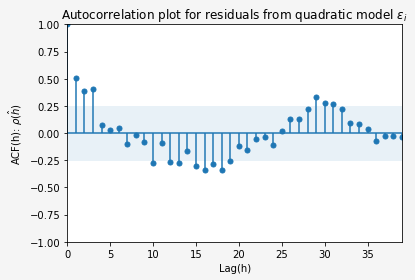

In [216]:
# Create plot
fig, ax = plt.subplots(nrows =1, ncols =1, facecolor = 'whitesmoke')

# Show +/- 1.96 standard deviations
upper_bound = 1.96/np.sqrt(len(ev_sales_zip_grouped))
lower_bound = -1.96/np.sqrt(len(ev_sales_zip_grouped))
ax.fill_between(np.arange(40), lower_bound, upper_bound, alpha = 0.1)
ax.set_xlim((0,39))
ax.set_xlabel("Lag(h)")
ax.set_ylabel(r"ACF(h): $\hat{\rho(h)}$")

# Show autocorrelation plot
plot_acf(errors_quadratic,ax=ax,lags = np.arange(40), alpha = None,
        title = "Autocorrelation plot for residuals from quadratic model $\epsilon_i$")

# Show
plt.show()

Again, ACF plot for residuals generated by the quadratic model suggests non-stationarity of the series of residuals. 

### Forecast

In [116]:
# Prepare data
predict_data["time2"]=predict_data["time"]**2

# Forecast
forecast_quadratic = lsdv_model_results_2.predict(predict_data)

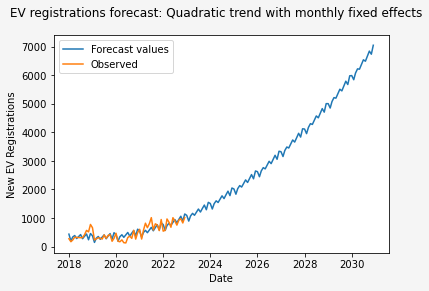

In [173]:
# Create figure
fig, ax = plt.subplots(nrows =1, ncols = 1, facecolor = 'whitesmoke')

# Plot and add axes
ax.plot(dates, forecast_quadratic, label = 'Forecast values')
ax.plot(ev_sales_zip_grouped["date"], ev_sales_zip_grouped_dummies["VEH_COUNT"], label = 'Observed')
ax.set_xlabel("Date")
ax.set_ylabel("New EV Registrations")

# Add legend
ax.legend(loc= 'best')

# Add title
plt.suptitle("EV registrations forecast: Quadratic trend with monthly fixed effects")

# Show
plt.show()

In [113]:
lsdv_model_results_2.predict(fake_data).sum()

365810.2557368327

Thus, modelling EV registrations as a quadratic function of time leads to a significantly higher forecast number of EV sales between 2018 and 2030. Nonetheless, this number does not reach the 500,000 EVs expected by DEEP (and this is before considering turnover of stock). This suggests that the aggregate trend in EV sales for 2023 onwards must *differ significantly* from the trend prior to 2023 in order to reach the target set by DEEP. 

Nonetheless, the forecast based on the quadratic model with fixed effects forms a baseline against which to compare forecasts developed using more sophisticated models in future.

# Model zip by zip

In this section, we estimate the models above individually for each zip code. This allows us to estimate separate seasonality effects, separate intercepts, and separate time trends for each zip code. 

**Note: this is equivalent to estimating a single model with group fixed effects,** interaction terms between each group and the seasonality dummies, and interaction terms between each group and the time trend. 

## Prepare data

In [19]:
# Get total sales by zip over the period 2018-
total_sales_by_zip = vehicle_sales.groupby(["ZIP_CODE", "year"]).sum()[["VEH_COUNT"]].reset_index().rename(columns = {"VEH_COUNT":"TOTAL_VEH_COUNT"})

# Match them
ev_sales_with_total = ev_sales_filled.merge(total_sales_by_zip,
                                    left_on = ["ZIP_CODE", "year"], right_on = ["ZIP_CODE", "year"])

In [20]:
# Get only those zip codes where more than 100 vehicles were sold in each of the five years
total_sales_by_zip["Over_100"] = (total_sales_by_zip["TOTAL_VEH_COUNT"]>100)*1
zips_years_over_100 = total_sales_by_zip.groupby("ZIP_CODE").sum().reset_index()[["ZIP_CODE", "Over_100"]]
zips_years_over_100 = zips_years_over_100[zips_years_over_100["Over_100"]==5]

In [21]:
# Get ev_sales_with_total only for these
ev_sales_with_total_filtered = ev_sales_with_total.merge(zips_years_over_100,
                                                        how = 'inner',
                                                        right_on = "ZIP_CODE",
                                                        left_on = "ZIP_CODE")

In [137]:
lin_model_dict = {}
quad_model_dict = {}

lin_predictions_dict = {}
quad_predictions_dict = {}

lin_errors_dict = {}
quad_errors_dict = {}

lin_forecast_dict = {}
quad_forecast_dict = {}

observed_dict = {}

failed_zips = []

In [138]:
# Create a dictionary with models in it
for zip_code in tqdm(list(ev_sales_with_total["ZIP_CODE"].unique())):
    try:
       # Create the data frame
        df = ev_sales_with_total[ev_sales_with_total["ZIP_CODE"]==zip_code][["VEH_COUNT", "year", "month", "day", "date"]]
        df = df.sort_values("date", ascending=True).reset_index().reset_index().rename(columns = {"level_0":"time"}).drop("index", axis=1)

        # Create dummies
        df["month"] = df["date"].astype(str).str[5:7]
        month_dummies = pd.get_dummies(df["month"], prefix = 'month')
        df = pd.concat([df, month_dummies], axis =1)
        
        # Create the quadratic time data
        df["time2"] = df["time"]**2

        # Estimate the linear model
        zip_model_lin = smf.ols(formula=form, data=df)
        zip_model_lin_results = zip_model_lin.fit()
        
        # Estimate the quadratic model
        zip_model_quad = smf.ols(formula=form_2, data = df)
        zip_model_quad_results = zip_model_quad.fit()

        # Add the linear and quadratic models to the respective dictionaries
        lin_model_dict[zip_code] = zip_model_lin_results
        quad_model_dict[zip_code] = zip_model_quad_results
        
        # Get linear predictions
        lin_predictions = zip_model_lin_results.predict(df)
        lin_predictions_dict[zip_code] = lin_predictions
        
        # Get quadratic predictions
        quad_predictions = zip_model_quad_results.predict(df)
        quad_predictions_dict[zip_code] = quad_predictions
        
        # Get errrors
        lin_errors_dict[zip_code] = df["VEH_COUNT"].to_list() - lin_predictions
        quad_errors_dict[zip_code] = df["VEH_COUNT"].to_list() - quad_predictions
        
        # Get linear forecast to 2030
        forecast_linear = zip_model_lin_results.predict(predict_data)
        lin_forecast_dict[zip_code] = forecast_linear
        
        # Get quadratic forecast to 2030
        forecast_quadratic = zip_model_quad_results.predict(predict_data)
        quad_forecast_dict[zip_code] = forecast_quadratic
        
        # Get real
        observed_dict[zip_code] = df[["year", "month", "VEH_COUNT"]]

    except Exception as e:
        print(e)
        failed_zips.append(zip_code)

100%|██████████| 352/352 [00:31<00:00, 11.24it/s]


In [139]:
# Transform the predictions into long format and save as a csv
zip_by_zip_predictions_lin = pd.DataFrame(lin_predictions_dict)
value_vars = pd.DataFrame(lin_predictions_dict).T.index
zip_by_zip_predictions_lin = pd.melt(pd.DataFrame(lin_predictions_dict).T.reset_index(), id_vars = 'index').rename(columns = {"index":"zip",
                                                                                  "variable":"time"}).sort_values(["zip","time"]).reset_index(drop=True)

In [140]:
# Create quad predictions
zip_by_zip_predictions_quad = pd.DataFrame(quad_predictions_dict)
value_vars = pd.DataFrame(quad_predictions_dict).T.index
zip_by_zip_predictions_quad = pd.melt(pd.DataFrame(quad_predictions_dict).T.reset_index(), id_vars = 'index').rename(columns = {"index":"zip",
                                                                                  "variable":"time"}).sort_values(["zip","time"]).reset_index(drop=True)

In [141]:
# Create quadratic forecast
quad_forecast = pd.melt(pd.DataFrame(quad_forecast_dict).reset_index().rename(columns = {"index":"time"}), id_vars = 'time')
quad_forecast = quad_forecast.rename(columns = {"variable":"zip"}).sort_values(["zip", "time"]).reset_index(drop=True)

quad_forecast.groupby("time").sum()["value"].sum()

376838.9827469659

In [142]:
# Get grouped linear
summed_zipwise_predictions_lin = zip_by_zip_predictions_lin.groupby("time").sum()[["value"]].reset_index()

# Get grouped quadratic
summed_zipwise_predictions_quad = zip_by_zip_predictions_quad.groupby("time").sum()[["value"]].reset_index()

## Visualize pooled data

**We visualize the in-sample predictions for the top 10 zip codes by sales of all vehicles**

In [183]:
top_10_zips = total_sales_by_zip.groupby("ZIP_CODE").sum().sort_values("TOTAL_VEH_COUNT",ascending=False).head(10).reset_index()["ZIP_CODE"].to_list()

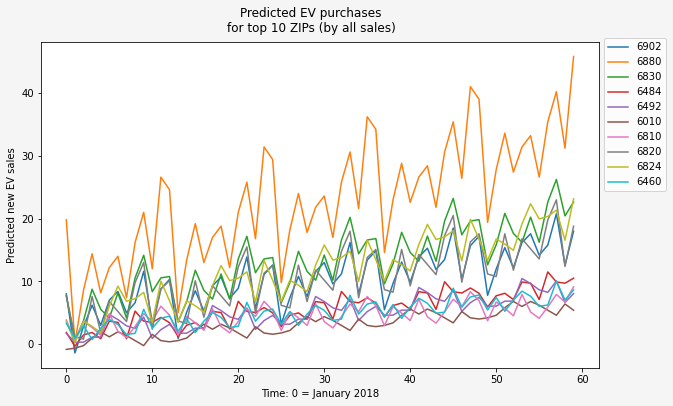

In [207]:
# Create figure
fig, ax = plt.subplots(nrows = 1, ncols =1, figsize = (10,6),facecolor = 'whitesmoke')

# Add axes labels
ax.set_xlabel("Time: 0 = January 2018")
ax.set_ylabel("Predicted new EV sales")

# Plot predictions
for zip_code in top_10_zips:
    ax.plot(zip_by_zip_predictions_lin[zip_by_zip_predictions_lin["zip"]==zip_code]["time"],
            zip_by_zip_predictions_lin[zip_by_zip_predictions_lin["zip"]==zip_code]["value"],
            label = zip_code)

# Add a legend
fig.legend(loc = 1, bbox_to_anchor = (1, 0.90))

# Add a title
fig.suptitle("Predicted EV purchases\nfor top 10 ZIPs (by all sales)", y =0.96)

# Show
plt.show()

# Proposed improved modelling approaches

The above analysis attempts to model new EV sales as a function of:
* Unobserved heterogeneity between zip codes
* Time
* Seasonality

However, a number of other factors have been shown in the literature to affect EV adoption, including:
* EV charging infrastructure (network effects)
* EV prices and subsidies (which are expected to decline over time)
* Fuel prices (which affect the vehicle ownership costs of an EV)
* EV model supply (especially the presence of lower-cost of EVs competing with lower-cost ICE vehicles)
* Environmental attitudes
* Learning-by doing (i.e. exposure to others purchasing EVs)
* Improved technology (improved operating cost, acceleration, fast-charging capabilities, and range)
* Heterogeneity between individuals (e.g. varied discount rates for for fuel prices, varied willingness to pay)
* Overall market size for light vehicles (driven by travel patterns, working patterns, geographic distribution of population, etc.) 

Accurately estimating demand requires consideration of these factors - particularly as large changes in the values of these variables (e.g., a significant increase in the availability of charging infrastructure, changes in price, learning-by-doing effects) may affect the trend in adoption in the future. 

### Improved modelling approaches

**1. Poisson model for count data.** 

Model the count of EVs sold in zip code $i$ at time $t$ as distributed according to a Poisson distribution where by $Pr[Y_{it} = y | \lambda_{it}] = \frac{\lambda_{it}^{y} e^{-\lambda_{it}}}{y!}$
* As shown in Gillingham and Tsvetanov 2019, the Poisson model is capable of incorporating:
    * Fixed effects for unobserved heterogeneity (which might be used to capture environmental attitudes, or other difficult-to-measure differences between zip codes*
    * Endogeneity of price (in our model, there is also endogeneity of charging infrastructure)
    * Excess zeroes (which are observed in 2018-2022 data)

**2. Probit model**

Where by the *probability* that an individual purchases a vehicle with attribute $y$ is modelled using the cumulative standard normal distribution function.

### Further data required

* Estimating the above models require further information on
    * Average EV price for each zip code, year, and month
    * Average income for each zip code, year, and month
    * EV charging infrastructure in each zip code, year, month
* Alternatively, some of the required parameters could be obtained from previous literature, meaning they would not need to be directly estimated